# MUSE

## Imports

In [1]:

import tarfile
import os
import os
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import classification_report
import joblib
import nltk
import torchaudio
from torch.nn.utils.rnn import pad_sequence
from transformers import AutoModel, AutoProcessor, AutoTokenizer, AutoFeatureExtractor
from tqdm import tqdm
from sklearn.metrics import balanced_accuracy_score

# Ensure NLTK data is downloaded
nltk.download('punkt')
nltk.download('stopwords')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

/home/lucamodica/mambaforge/envs/muse/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /home/lucamodica/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lucamodica/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
text_model_name = "bert-base-uncased"
audio_model_name = "openai/whisper-small"

## Data

In [2]:
def get_root_dir(split):
    return f'data/{split}'

### Utils

In [3]:
def meld_collate_fn(batch):
    # batch is a list of conversation dicts (one per item in dataset)
    # We can combine them into a single batch,
    # but each conversation may have different # of utterances.

    dialog_ids = []
    audio_lists = []
    text_lists = []
    emotion_lists = []
    sentiment_lists = []

    for conv in batch:
        dialog_ids.append(conv["dialog_id"])

        # Convert audio_list (list of numpy arrays) to tensors and pad
        fbank_tensors = [torch.tensor(fbank) for fbank in conv["audio_list"]]
        # Pad along the time dim (T)
        fbank_padded = pad_sequence(fbank_tensors, batch_first=True)
        audio_lists.append(fbank_padded)

        text_lists.append(conv["text_list"])
        emotion_lists.append(torch.tensor(conv["emotion_list"]))
        sentiment_lists.append(torch.tensor(conv["sentiment_list"]))

    # Return them "as is", or do further padding if needed.
    return {
        "dialog_ids": dialog_ids,
        "audio_lists": audio_lists,
        "text_lists": text_lists,
        "emotion_lists": emotion_lists,
        "sentiment_lists": sentiment_lists
    }


def custom_text_preprocessor(text):
    return text

### fbanks extractor

In [4]:
import torchaudio
import torch
import torchaudio.transforms as T

def wav2fbank(filename):
    waveform, sr = torchaudio.load(filename)
    waveform = waveform - waveform.mean()

    try:
        fbank = torchaudio.compliance.kaldi.fbank(
            waveform,
            htk_compat=True,
            sample_frequency=sr,
            use_energy=False,
            window_type='hanning',
            num_mel_bins=128,
            dither=0.0,
            frame_shift=10
        )
    except:
        fbank = torch.zeros([512, 128]) + 0.01
        print('there is a loading error')

    target_length = 1024
    n_frames = fbank.shape[0]

    p = target_length - n_frames

    # cut and pad
    if p > 0:
        m = torch.nn.ZeroPad2d((0, 0, 0, p))
        fbank = m(fbank)
    elif p < 0:
        fbank = fbank[0:target_length, :]

    return fbank

### apply fbanks extractor to convert audio

In [5]:
# convert audio to fbank from train, dev and test
# for split in ['train', 'dev', 'test']:
#     root_dir = get_root_dir(split)
#     df = pd.read_csv(f'{root_dir}/{split}_sent_emo.csv')
#     for i, row in df.iterrows():
#         dia_id = row['Dialogue_ID']
#         utt_id = row['Utterance_ID']
#         audio_file = f'{root_dir}/audio/dia{dia_id}_utt{utt_id}.wav'
#         fbank_file = f'{root_dir}/fbank/dia{dia_id}_utt{utt_id}.npy'
        
#         # create the fbank directory if it does not exist
#         if not os.path.exists(f'{root_dir}/fbank/'):
#             os.makedirs(f'{root_dir}/fbank/')
        
#         # check if the fbank file already exists
#         if not os.path.exists(f'{root_dir}/fbank/dia{dia_id}_utt{utt_id}.npy'):
#             fbank = wav2fbank(audio_file)
#             fbank = fbank.numpy()
#             np.save(f'{root_dir}/fbank/dia{dia_id}_utt{utt_id}.npy', fbank)
#         else:
#             print(f'{fbank_file} already exists')

### Dataset and dataloader class

In [7]:
import pandas as pd
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset
import torch


class MELDConversationDataset(Dataset):
    def __init__(self, csv_file, 
        root_dir='./data',
        processor=None,
        audio_transform=None,
        text_transform=None, 
        target_length=1024):
        """
        Dataset class for MELD conversations with support for torchaudio transforms.

        :param csv_file: Path to the CSV file with conversation metadata.
        :param root_dir: Root directory containing audio files (default: './data').
        :param audio_transform: A torchaudio transform to apply to the waveform (default: None).
                                If None, the raw waveform is used.
        :param target_length: Number of time frames to pad or truncate to (default: 1024).
        """
        df = pd.read_csv(f'{root_dir}/{csv_file}')

        # Order the dataframe rows by Dialogue_ID and Utterance_ID
        df = df.sort_values(by=['Dialogue_ID', 'Utterance_ID'])

        # Class counts for emotions and sentiments
        self.emotion_class_counts = {i: 0 for i in range(7)}
        self.sentiment_class_counts = {i: 0 for i in range(3)}
        self.max_dialogue_size = 0

        self.dialogues = {}  # key: dialogue_id, value: list of utterance dicts
        self.audio_transform = audio_transform
        self.text_transform = text_transform
        self.target_length = target_length
        self.processor = processor
        prev_dia_id = None
        utt_count = 0

        # Iterate through the dataframe to build the dialogues
        for _, row in df.iterrows():
            dia_id = row["Dialogue_ID"]
            utt_id = row["Utterance_ID"]

            # Update max dialogue size
            if prev_dia_id == dia_id:
                utt_count += 1
            else:
                if utt_count > self.max_dialogue_size:
                    self.max_dialogue_size = utt_count
                utt_count = 1

            # Get audio file path
            audio_file = f'{root_dir}/audio/dia{dia_id}_utt{utt_id}.wav'

            # Load the waveform using torchaudio
            try:
                waveform, sr = torchaudio.load(audio_file)
                
                # If the audio is stereo (2 channels), convert it
                # to mono by averaging the channels
                if waveform.size(0) > 1:
                    waveform = waveform.mean(dim=0, keepdim=True)

                # Apply audio transform if provided, otherwise use raw waveform
                if self.audio_transform:
                    audio_features = self.audio_transform(waveform, sr)
                else:
                    audio_features = waveform
                    
                # Apply processor if provided
                if self.processor:
                    # Process waveform into log-Mel spectrogram using WhisperProcessor
                    inputs = self.processor.feature_extractor(
                        waveform.squeeze(0), sampling_rate=16000, return_tensors="pt"
                    )
                    input_features = inputs.input_features[0]  # Extract the spectrogram
                    audio_features = input_features
                    

            except Exception as e:
                print(f"Error loading or processing audio file {audio_file}: {e}")
                audio_features = torch.zeros(
                    (1, self.target_length))  # Fallback to silence

            # Process emotion and sentiment labels
            emotion = row["Emotion"].lower()
            emotion_int = self.emotion_to_int(emotion)
            sentiment = row["Sentiment"].lower()
            sentiment_int = self.sentiment_to_int(sentiment)

            # Update class counts
            self.emotion_class_counts[emotion_int] += 1
            self.sentiment_class_counts[sentiment_int] += 1

            utter_dict = {
                "audio_features": audio_features,
                "transcript": row["Utterance"],
                "emotion": emotion_int,
                "sentiment": sentiment_int
            }

            # Add utterance to the corresponding dialogue
            if dia_id not in self.dialogues:
                self.dialogues[dia_id] = []
            self.dialogues[dia_id].append(utter_dict)

            prev_dia_id = dia_id

        # Convert to a list of (dialog_id, list_of_utterances)
        self.dialogues = [(k, v) for k, v in self.dialogues.items()]

    def _pad_or_truncate(self, audio_features):
        """
        Pad or truncate audio features to the target length.

        :param audio_features: Tensor of audio features with shape [n_mels, time_steps].
        :return: Padded or truncated tensor with shape [n_mels, target_length].
        """
        n_mels, n_frames = audio_features.shape

        if n_frames < self.target_length:
            # Pad with zeros if the spectrogram is too short
            pad_amount = self.target_length - n_frames
            audio_features = torch.nn.functional.pad(
                audio_features, (0, pad_amount), mode="constant", value=0)
        elif n_frames > self.target_length:
            # Truncate if the spectrogram is too long
            audio_features = audio_features[:, :self.target_length]

        return audio_features

    def emotion_to_int(self, emotion):
        """
        Map emotion labels to integers.
        """
        str_to_int = {"neutral": 0, "joy": 1, "surprise": 2,
                      "anger": 3, "sadness": 4, "fear": 5, "disgust": 6}
        return str_to_int[emotion]

    def emotion_to_str(self, emotion_int):
        """
        Map integers to emotion labels.
        """
        int_to_str = {0: "neutral", 1: "joy", 2: "surprise",
                      3: "anger", 4: "sadness", 5: "fear", 6: "disgust"}
        return int_to_str[emotion_int]

    def sentiment_to_int(self, sentiment):
        """
        Map sentiment labels to integers.
        """
        str_to_int = {"neutral": 0, "positive": 1, "negative": 2}
        return str_to_int[sentiment]

    def sentiment_to_str(self, sentiment_int):
        """
        Map integers to sentiment labels.
        """
        int_to_str = {0: "neutral", 1: "positive", 2: "negative"}
        return int_to_str[sentiment_int]

    def __len__(self):
        """
        Return the number of dialogues.
        """
        return len(self.dialogues)

    def __getitem__(self, idx):
        """
        Get a dialogue by index.
        """
        dialog_id, utterances = self.dialogues[idx]

        # Prepare lists for audio features, transcripts, emotions, and sentiments
        audio_list = []
        text_list = []
        emotion_list = []
        sentiment_list = []

        for utt in utterances:
            audio_list.append(utt["audio_features"])
            text_list.append(utt["transcript"])
            emotion_list.append(utt["emotion"])
            sentiment_list.append(utt["sentiment"])

        return {
            "dialog_id": dialog_id,
            "audio_list": audio_list,
            "text_list": text_list,
            "emotion_list": emotion_list,
            "sentiment_list": sentiment_list
        }

In [77]:
# class MELDConversationDataset(Dataset):
#     def __init__(self, csv_file, root_dir='./data', text_processor=None, audio_processor=None):
#         """
#         We'll store a list of (dialog_id, [list_of_utterance_dicts]).
#         Each utterance_dict might contain:
#           {
#             "fbank_path": str,
#             "transcript": str,
#             "emotion": int,
#             "sentiment": int
#           }
#         """
#         df = pd.read_csv(f'{root_dir}/{csv_file}')

#         # order the df rows according to dialogueID and each dialogue according to utteranceID
#         df = df.sort_values(by=['Dialogue_ID', 'Utterance_ID'])

#         self.emotion_class_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}
#         self.sentiment_class_counts = {0: 0, 1: 0, 2: 0}
#         self.max_dialogue_size = 0

#         self.dialogues = {}  # key: dialogue_id, value: list of utterance dicts
#         prev_dia_id = None
#         utt_count = 0

#         for _, row in df.iterrows():

#             dia_id = row["Dialogue_ID"]
#             utt_id = row["Utterance_ID"]

#             if prev_dia_id == dia_id:
#                 utt_count += 1
#             else:
#                 if utt_count > self.max_dialogue_size:
#                     self.max_dialogue_size = utt_count
#                 utt_count = 1

#             fbank_path = f'{root_dir}/fbank/dia{dia_id}_utt{utt_id}.npy'
            
#             # get the waveform file and convert it into
#             # mel spectrogram
#             audio_file = f'{root_dir}/audio/dia{dia_id}_utt{utt_id}.wav'
#             mel_spectrogram = waveform_to_logmel(waveform=torchaudio.load(audio_file)[0])

#             emotion = row["Emotion"]
#             emotion = emotion.lower()
#             emotion_int = self.emotion_to_int(emotion)
#             sentiment = row["Sentiment"]
#             sentiment = sentiment.lower()
#             sentiment_int = self.sentiment_to_int(sentiment)

#             self.emotion_class_counts[emotion_int] += 1
#             self.sentiment_class_counts[sentiment_int] += 1

#             utter_dict = {
#                 "fbank_path": fbank_path,
#                 "transcript": row["Utterance"],
#                 "emotion": emotion_int,
#                 "sentiment": sentiment_int
#             }

#             if dia_id not in self.dialogues:
#                 self.dialogues[dia_id] = []
#             self.dialogues[dia_id].append(utter_dict)

#             prev_dia_id = dia_id

#         # Convert to list of (dialog_id, list_of_utterances)
#         self.dialogues = [(k, sorted(v, key=lambda x: x["fbank_path"]))
#                           for k, v in self.dialogues.items()]
#         # The sorting step ensures the utterances are in ascending order of utt_id if needed.

#     def emotion_to_int(self, str):
#         str_to_int = {"neutral": 0, "joy": 1, "surprise": 2,
#                       "anger": 3, "sadness": 4, "fear": 5, "disgust": 6}
#         return str_to_int[str]

#     def emotion_to_str(self, int):
#         int_to_str = {0: "neutral", 1: "joy", 2: "surprise",
#                       3: "anger", 4: "sadness", 5: "fear", 6: "disgust"}
#         return int_to_str[int]

#     def sentiment_to_int(self, str):
#         str_to_int = {"neutral": 0, "positive": 1, "negative": 2}
#         return str_to_int[str]

#     def sentiment_to_str(self, int):
#         int_to_str = {0: "neutral", 1: "positive", 2: "negative"}
#         return int_to_str[int]

#     def __len__(self):
#         return len(self.dialogues)

#     def __getitem__(self, idx):
#         dialog_id, utterances = self.dialogues[idx]

#         # For each utterance, load filterbanks, transcript, emotion, sentiment
#         audio_list = []
#         text_list = []
#         emotion_list = []
#         sentiment_list = []

#         for utt in utterances:
#             # shape e.g. (T, fbank_dim)
#             fbank = np.load(utt["fbank_path"])
#             audio_list.append(fbank)

#             text_list.append(utt["transcript"])
#             emotion_list.append(utt["emotion"])         # or mapped to int
#             sentiment_list.append(utt["sentiment"])     # or mapped to int

#         return {
#             "dialog_id": dialog_id,
#             "audio_list": audio_list,
#             "text_list": text_list,
#             "emotion_list": emotion_list,
#             "sentiment_list": sentiment_list
#         }

In [8]:
class AudioTransformPipeline:
    """
    Custom pipeline for chaining multiple audio transformations with dynamic resampling.
    """

    def __init__(self, target_sample_rate=16000, n_mels=128):
        self.target_sample_rate = target_sample_rate
        self.n_mels = n_mels

    def __call__(self, waveform, orig_sample_rate):
        audio = waveform
        
        # Step 1: Resample if the original sample rate is different
        if orig_sample_rate != self.target_sample_rate:
            resampler = T.Resample(
                orig_freq=orig_sample_rate, new_freq=self.target_sample_rate)
            audio = resampler(audio)

        # Step 2: Convert to Mel Spectrogram
        # mel_transform = T.MelSpectrogram(
        #     sample_rate=self.target_sample_rate, n_mels=self.n_mels)
        # mel_spec = mel_transform(waveform)

        # Step 3: Convert amplitude to decibels
        # db_transform = T.AmplitudeToDB()
        # mel_spec_db = db_transform(mel_spec)
        
        return audio

def log_mel_transform(waveform, sample_rate=16000, n_fft=400, hop_length=160, n_mels=128):
    """
    Convert a waveform to a log Mel spectrogram using torchaudio.transforms.

    :param waveform: Tensor of shape [channels, time] or [time].
    :param sample_rate: Sampling rate of the input waveform (default: 16000).
    :param n_fft: Number of FFT bins (default: 400).
    :param hop_length: Hop length between frames (default: 160).
    :param n_mels: Number of Mel filterbank channels (default: 128).
    :return: Log Mel spectrogram tensor of shape [n_mels, time_steps].
    """
    # Ensure the waveform is 2D (channels, time)
    if len(waveform.shape) == 1:  # If 1D, add a channel dimension
        waveform = waveform.unsqueeze(0)

    # Downmix to mono if more than 1 channel
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)

    # Define the MelSpectrogram transform
    mel_spectrogram_transform = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        power=2.0  # Use power spectrogram (not amplitude)
    )

    # Apply the MelSpectrogram transform
    mel_spectrogram = mel_spectrogram_transform(
        waveform)  # Shape: [1, n_mels, time_steps]

    # Take the log of the Mel spectrogram, ensuring no log(0) or negative values
    log_mel = torch.log(mel_spectrogram + 1e-6)  # Add epsilon to avoid log(0)

    return log_mel.squeeze(0)  # Remove the channel dimension for consistency

def log_mel_transform_fn(waveform): return log_mel_transform(
    waveform, sample_rate=16000)

In [9]:
# Define the custom transformation pipeline
audio_processor = AutoProcessor.from_pretrained(audio_model_name)
audio_transform = AudioTransformPipeline()

train_set = MELDConversationDataset(
    csv_file="train_sent_emo.csv", 
    root_dir="data/train",
    audio_transform=audio_transform,
    target_length=1024,
    processor=audio_processor
)
dev_set = MELDConversationDataset(
    csv_file="dev_sent_emo.csv", 
    root_dir="data/dev",
    audio_transform=audio_transform,
    target_length=1024,
    processor=audio_processor
)
test_set = MELDConversationDataset(
    csv_file='test_sent_emo.csv', 
    root_dir='data/test',
    audio_transform=audio_transform,
    target_length=1024,
    processor=audio_processor
)

print("Data loaded.")

# train_loader = DataLoader(train_set, batch_size=4, shuffle=True, num_workers=4, collate_fn=meld_collate_fn)
# dev_loader = DataLoader(dev_set, batch_size=4, shuffle=True, num_workers=4, collate_fn=meld_collate_fn)
# test_loader = DataLoader(test_set, batch_size=4, shuffle=True, num_workers=4, collate_fn=meld_collate_fn)

print("Data loaders created.")

Data loaded.
Data loaders created.


### Miscs

In [38]:
print(len(train_set), len(dev_set), len(test_set))

1038 114 169


In [39]:
num_emotions = len(train_set.emotion_class_counts)
num_sentiments = len(train_set.sentiment_class_counts)

print("Number of emotions:", num_emotions)
print("Number of sentiments:", num_sentiments)

for i in range(7):
    print(f"Emotion {train_set.emotion_to_str(i)} count:", train_set.emotion_class_counts[i])
for i in range(3):
    print(f"Sentiment {train_set.sentiment_to_str(i)} count:", train_set.sentiment_class_counts[i])
    
print("\n")

Number of emotions: 7
Number of sentiments: 3
Emotion neutral count: 4709
Emotion joy count: 1743
Emotion surprise count: 1205
Emotion anger count: 1109
Emotion sadness count: 683
Emotion fear count: 268
Emotion disgust count: 271
Sentiment neutral count: 4709
Sentiment positive count: 2334
Sentiment negative count: 2945




In [40]:
#get weights for balancing classes
class_counts = train_set.emotion_class_counts
total_samples = 0

for key in class_counts:
    total_samples += class_counts[key]
    
print("Total samples:", total_samples)
class_weights = torch.zeros(len(class_counts))

for i in range(len(class_counts)):
    class_weights[i] = class_counts[i] / total_samples
    
class_weights = 1 / class_weights  # invert the weights
class_weights = class_weights / class_weights.sum()  # normalize the weights
class_weights = class_weights.to(device)
print("Class weights:", class_weights)

Total samples: 9988
Class weights: tensor([0.0186, 0.0503, 0.0728, 0.0791, 0.1284, 0.3272, 0.3236])


In [41]:
# set max utterance size to be the max of all train dev and test sets
max_utt = max(train_set.max_dialogue_size,
              dev_set.max_dialogue_size, test_set.max_dialogue_size)
print("Max dialogue size:", max_utt)

Max dialogue size: 24


mel spectrogram shape: torch.Size([80, 3000])


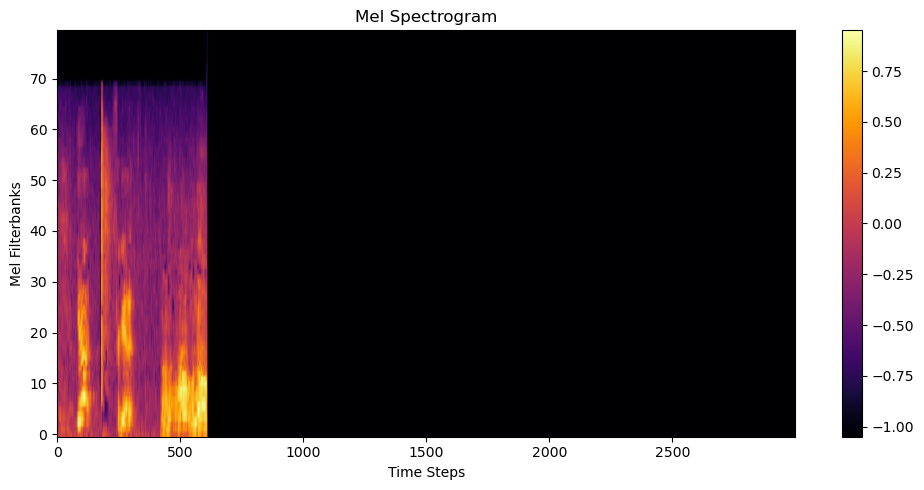

In [19]:
# display mel spectrogram from an example
mel_spectrogram = train_set[1]["audio_list"][1]
print(f'mel spectrogram shape: {mel_spectrogram.shape}')
plt.figure(figsize=(10, 5))
plt.imshow(mel_spectrogram.cpu().numpy(), aspect="auto", origin="lower", cmap="inferno")
plt.colorbar()
plt.title("Mel Spectrogram")
plt.xlabel("Time Steps")
plt.ylabel("Mel Filterbanks")
plt.tight_layout()
plt.show()

## Embeddings

### Encoders

In [20]:
from transformers import AutoModel, AutoProcessor
import torch
import torch.nn as nn


class AudioEncoder(nn.Module):
    def __init__(self, model_name, fine_tune=False, unfreeze_last_n=2):
        super(AudioEncoder, self).__init__()

        # Load the processor (handles feature extraction)
        # Works for Wav2Vec2, HuBERT, Whisper, etc.
        self.processor = AutoProcessor.from_pretrained(model_name)

        # Load the model
        self.model = AutoModel.from_pretrained(model_name)

        # Freeze the entire model by default
        for param in self.model.parameters():
            param.requires_grad = False

        # Fine-tune the last `unfreeze_last_n` layers, if specified
        if fine_tune:
            # Check if encoder layers exist
            if hasattr(self.model, "encoder") and hasattr(self.model.encoder, "layers"):
                total_layers = len(self.model.encoder.layers)
                for layer_idx in range(total_layers - unfreeze_last_n, total_layers):
                    for param in self.model.encoder.layers[layer_idx].parameters():
                        param.requires_grad = True
            else:
                print(f"Warning: Unfreezing layers is not supported for {model_name}")

    def forward(self, audios):
        """
        Forward pass to process audio and extract embeddings.

        :param audios: Tensor of raw audio waveforms (shape: [batch_size, num_samples])
        :return: Mean-pooled audio embeddings (shape: [batch_size, hidden_size])
        """
        # Ensure the waveforms are on the correct device
        audios = audios.to(self.device)

        # Forward pass through the model
        with torch.no_grad() if not self.training or not any(
            p.requires_grad for p in self.model.parameters()
        ) else torch.enable_grad():
            outputs = self.model(**audios)

        # Extract hidden states
        if hasattr(outputs, "last_hidden_state"):
            # shape: [batch_size, time_steps, hidden_size]
            hidden_states = outputs.last_hidden_state
        elif hasattr(outputs, "hidden_states"):
            # Use the last layer's hidden states
            hidden_states = outputs.hidden_states[-1]
        else:
            raise ValueError(
                f"Model {self.model.config.model_type} does not output hidden states.")

        # Mean pooling over the time dimension to get fixed-size embeddings
        # shape: [batch_size, hidden_size]
        audio_emb = hidden_states.mean(dim=1)

        return audio_emb

class TextEncoder(nn.Module):
    """
    Encodes text using a pretrained BERT model from Hugging Face.
    """

    def __init__(self,
                 model_name="distilbert-base-uncased",
                 fine_tune=False,
                 unfreeze_last_n_layers=2,
                 device=device):
        super(TextEncoder, self).__init__()
        # self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(device)

        # If we're not fine-tuning at all, freeze everything.
        # Otherwise, freeze everything first, then selectively unfreeze layers.
        for param in self.model.parameters():
            param.requires_grad = False

        if fine_tune and unfreeze_last_n_layers > 0:
            # For BERT-base, there are 12 encoder layers: encoder.layer[0] ... encoder.layer[11].
            # Unfreeze the last N layers:
            total_layers = len(self.model.transformer.layer)
            for layer_idx in range(total_layers - unfreeze_last_n_layers, total_layers):
                for param in self.model.transformer.layer[layer_idx].parameters():
                    param.requires_grad = True

            # Optionally unfreeze the pooler layer if you use it
            # for param in self.model.pooler.parameters():
             #   param.requires_grad = True

    def forward(self, text_list):
        """
        :param text_list: A list of strings (or a single string) to encode.
        :return: A tensor of shape [batch_size, hidden_dim] with text embeddings
        """
        device = self.model.device

        # If a single string is passed, wrap it into a list
        if isinstance(text_list, str):
            text_list = [text_list]

        encodings = self.tokenizer(
            text_list,
            padding=True,
            truncation=True,
            return_tensors="pt"
        ).to(device)

        # If all parameters are frozen (no grad), then no_grad() is fine.
        # But if some layers are unfrozen, we want torch.enable_grad()
        # so that backprop can proceed for those layers.
        use_grad = any(p.requires_grad for p in self.model.parameters())
        with torch.enable_grad() if use_grad else torch.no_grad():
            outputs = self.model(
                input_ids=encodings.input_ids,
                attention_mask=encodings.attention_mask
            )

        # outputs.last_hidden_state -> shape [batch_size, seq_len, hidden_dim]
        # Typically we use the [CLS] token embedding as a single representation
        cls_emb = outputs.last_hidden_state[:, 0, :]  # shape [B, hidden_dim]
        return cls_emb

### Dataset class for embeddings

In [43]:
class DialogueEmbeddingDataset(Dataset):
    def __init__(self, audio_embs, text_embs, emotion_labels, sentiment_labels, dialogue_ids):
        """
        :param audio_embs:       List of FloatTensors [num_dialogues, num_utterances, audio_dim]
        :param text_embs:        List of FloatTensors [num_dialogues, num_utterances, text_dim]
        :param emotion_labels:   List of lists (dialogue-level emotion labels) [num_dialogues, num_utterances]
        :param sentiment_labels: List of lists (dialogue-level sentiment labels) [num_dialogues, num_utterances]
        :param dialogue_ids:     List of dialogue IDs [num_dialogues]
        """
        self.audio_embs = audio_embs
        self.text_embs = text_embs
        self.emotion_labels = emotion_labels
        self.sentiment_labels = sentiment_labels
        self.dialogue_ids = dialogue_ids

    def __len__(self):
        return len(self.audio_embs)

    def __getitem__(self, idx):
        return {
            "dialog_id": self.dialogue_ids[idx],
            "audio_lists": self.audio_embs[idx],
            "text_lists": self.text_embs[idx],
            "emotion_lists": self.emotion_labels[idx],
            "sentiment_lists": self.sentiment_labels[idx]
        }


def build_embedding_dataset(dataset, audio_encoder, text_encoder, audio_feature_extractor: AutoFeatureExtractor):
    """
    Processes a MELDConversationDataset, computes audio and text embeddings for each utterance
    in all dialogues, and returns a new dataset with embeddings instead of raw features.
    
    :param dataset: Instance of MELDConversationDataset (raw dataset with FBanks and transcripts).
    :param audio_encoder: Pretrained Whisper model wrapped in an AudioEncoder class.
    :param text_encoder: Pretrained text encoder (e.g., BERT or similar).
    :param device: Device to perform inference on (default: 'cuda').
    :return: New dataset with audio and text embeddings.
    """
    # Ensure the encoders are in evaluation mode
    audio_encoder.eval()
    text_encoder.eval()

    all_dialogue_audio_embs = []
    all_dialogue_text_embs = []
    all_emotion_labels = []
    all_sentiment_labels = []
    all_dialogue_ids = []

    for idx in range(len(dataset)):
        data = dataset[idx]
        dialog_id = data["dialog_id"]
        audio_list = data["audio_list"]
        text_list = data["text_list"]
        emotion_list = data["emotion_list"]
        sentiment_list = data["sentiment_list"]

        dialogue_audio_embs = []
        dialogue_text_embs = []

        with torch.no_grad():
            for audio, text in zip(audio_list, text_list):

                # Step 2: Compute audio embedding using Whisper
                print(audio.shape)
                
                if audio_feature_extractor:
                    audio_emb = audio_feature_extractor(audio, return_tensors="pt").to(device)
                else:
                    audio_emb = audio_encoder(audio.unsqueeze(0))
                
                dialogue_audio_embs.append(audio_emb.cpu())

                # Step 3: Compute text embedding using the text encoder
                # Replace with your text encoder (e.g., BERT)
                text_emb = text_encoder(text)
                # Remove batch dimension if present
                text_emb = text_emb.squeeze(0)
                dialogue_text_embs.append(text_emb.cpu())

        # Stack embeddings for all utterances in the dialogue
        s = torch.stack(dialogue_audio_embs)
        dialogue_text_embs = torch.stack(dialogue_text_embs)

        # Append dialogue-level data
        all_dialogue_audio_embs.append(dialogue_audio_embs)
        all_dialogue_text_embs.append(dialogue_text_embs)
        all_emotion_labels.append(emotion_list)
        all_sentiment_labels.append(sentiment_list)
        all_dialogue_ids.append(dialog_id)

    # Build the new DialogueEmbeddingDataset
    emb_dataset = DialogueEmbeddingDataset(
        audio_embs=all_dialogue_audio_embs,
        text_embs=all_dialogue_text_embs,
        emotion_labels=all_emotion_labels,
        sentiment_labels=all_sentiment_labels,
        dialogue_ids=all_dialogue_ids
    )
    return emb_dataset

In [44]:
# audio_model_name = "openai/whisper-base"
text_model_name = "bert-base-uncased"

# audio_encoder = AudioEncoder(model_name=audio_model_name)
text_encoder = TextEncoder(model_name=text_model_name)

# Load an AST model and its feature extractor
feature_extractor = AutoFeatureExtractor.from_pretrained(
    "MIT/ast-finetuned-audioset-10-10-0.4593")

# Initialize the AudioEncoder with the feature extractor and model
audio_encoder = AudioEncoder(feature_extractor=feature_extractor)

/home/lucamodica/mambaforge/envs/muse/lib/python3.12/site-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [65]:
train_emb_dataset = build_embedding_dataset(train_set, audio_encoder, text_encoder, feature_extractor)
dev_emb_dataset = build_embedding_dataset(dev_set, audio_encoder, text_encoder, feature_extractor)
test_emb_dataset = build_embedding_dataset(test_set, audio_encoder, text_encoder, feature_extractor)

It is strongly recommended to pass the `sampling_rate` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


torch.Size([128, 1024])


AssertionError: choose a window size 400 that is [2, 128]

## Model

In [55]:
# PARAMETERS
lr = 1e-4
criterions = {
    'emotion': nn.CrossEntropyLoss(weight=class_weights),
    'sentiment': nn.CrossEntropyLoss()
}
num_epochs = 50

In [ ]:

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None, dropout_p=0.5):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError(
                'BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError(
                "Dilation > 1 not supported in BasicBlock")

        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=dropout_p)  # Dropout layer added
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)  # apply dropout after first ReLU

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        out = self.dropout(out)  # apply dropout after second ReLU

        return out

### BasicBlock class

In [56]:
class ResNet(nn.Module):

    def __init__(self, block, layers, modality, num_classes=1000, pool='avgpool', zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        self.modality = modality
        self.pool = pool
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        if modality == 'audio':
            self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=7, stride=2, padding=3,
                                   bias=False)
        elif modality == 'visual':
            self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                                   bias=False)
        else:
            raise NotImplementedError(
                'Incorrect modality, should be audio or visual but got {}'.format(modality))

        self.out_conv = nn.Conv2d(
            512 * block.expansion, 768, kernel_size=1, stride=1, bias=False)

        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.normal_(m.weight, mean=1, std=0.02)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):

        if self.modality == 'visual':
            (B, C, T, H, W) = x.size()
            x = x.permute(0, 2, 1, 3, 4).contiguous()
            x = x.view(B * T, C, H, W)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.out_conv(x)  # Now x has shape [B, 768, H_out, W_out]

        out = x

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


def _resnet(arch, block, layers, modality, progress, **kwargs):
    model = ResNet(block, layers, modality, **kwargs)
    return model


def resnet18(modality, progress=True, **kwargs):
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], modality, progress,
                   **kwargs)

In [16]:
class FusionLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_layers=1, bidirectional=False, dropout=0.1):
        super(FusionLSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.hidden_dim = hidden_dim * (2 if bidirectional else 1)

    def forward(self, x):
        """
        x: (batch_size, seq_len, input_dim)
        returns: (batch_size, seq_len, hidden_dim)
        """
        output, (hn, cn) = self.lstm(x)
        return output, (hn, cn)  # output is the sequence of hidden states


class MultimodalClassifierWithLSTM(nn.Module):
    def __init__(self, 
        audio_encoder, text_encoder, fusion_lstm, 
        hidden_dim=256, num_emotions=7, num_sentiments=3, 
        max_utt=50, compute_emb=False):
        super(MultimodalClassifierWithLSTM, self).__init__()
        self.audio_encoder = audio_encoder
        self.text_encoder = text_encoder
        self.fusion_lstm = fusion_lstm  # e.g., an instance of FusionLSTM
        self.emotion_head = nn.Linear(hidden_dim*2, num_emotions)
        self.sentiment_head = nn.Linear(hidden_dim*2, num_sentiments)
        self.max_utt = max_utt
        self.compute_emb = compute_emb

    def forward(self, audio_dialog_utts, text_dialog_utts):

        if self.compute_emb:
            audio_emb = self.audio_encoder(audio_dialog_utts)
            audio_emb = F.adaptive_avg_pool2d(audio_emb, 1)
            audio_emb = torch.flatten(audio_emb, 1)

            text_emb = [self.text_encoder(utt) for utt in text_dialog_utts]
            text_emb = torch.stack(text_emb)  # shape (B, hidden_dim)

            text_emb = text_emb.squeeze(1)
        else:
            audio_emb = audio_dialog_utts
            text_emb = text_dialog_utts

        # print("Final Audio emb shape: ", audio_emb.shape)
        # print("Final Text emb shape: ", text_emb.shape)

        # Combine
        # (utts, audio_enc_dim + text_enc_dim)
        fused_emb = torch.cat([audio_emb, text_emb], dim=-1)

        # Reshape back to (B, S, fused_dim) for the LSTM
        # (1, utts, audio_enc_dim + text_enc_dim)
        fused_emb = fused_emb.unsqueeze(0)

        padded_fused_emb = F.pad(
            fused_emb, (0, 0, 0, self.max_utt - fused_emb.size(1)))

        # Pass through LSTM
        lstm_out, (hn, cn) = self.fusion_lstm(padded_fused_emb)

        # print("LSTM out shape: ", lstm_out.shape)

        lstm_out = lstm_out.squeeze(0)

        # Classification heads

        emotion_logits = self.emotion_head(lstm_out)
        sentiment_logits = self.sentiment_head(lstm_out)

        return emotion_logits, sentiment_logits

In [58]:
model = MultimodalClassifierWithLSTM(
    fusion_lstm=FusionLSTM(input_dim=1536, hidden_dim=256, num_layers=1, bidirectional=True, dropout=0.2),
    audio_encoder=resnet18(modality='audio'),
    text_encoder=TextEncoder(fine_tune=True, unfreeze_last_n_layers=1),
    hidden_dim=256,
    num_emotions=num_emotions,
    num_sentiments=num_sentiments,
    max_utt=max_utt
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.0001)
experiment_name = 'TEST'

## Training

In [59]:
def train_one_epoch(model, dataloader, optimizer, criterions, emotion_reg=0.5, sentiment_reg=0.5, device='cuda'):
    model.train()

    losses = {'emotion': 0.0, 'sentiment': 0.0}
    metrics = {
        'emotion': {'fused': [], 'labels': []},
        'sentiment': {'fused': [], 'labels': []}
    }

    loop = tqdm(dataloader, desc="Training", leave=False)

    for batch in loop:
        batch_emotion_loss = 0.0
        batch_sentiment_loss = 0.0

        batch_emotion_preds = []
        batch_emotion_labels = []
        batch_sentiment_preds = []
        batch_sentiment_labels = []

        for b_idx in range(len(batch["dialog_ids"])):
            audio_list = batch["audio_lists"][b_idx]
            text_list = batch["text_lists"][b_idx]
            emotion_list = batch["emotion_lists"][b_idx]
            sentiment_list = batch["sentiment_lists"][b_idx]

            # Determine the actual number of utterances before padding
            # Number of real utterances in this conversation
            actual_len = len(emotion_list)

            # Convert lists to tensors
            emotion_tensor = torch.as_tensor(
                emotion_list, dtype=torch.long, device=device)
            sentiment_tensor = torch.as_tensor(
                sentiment_list, dtype=torch.long, device=device)
            audio_array = torch.as_tensor(
                audio_list, dtype=torch.float, device=device)

            audio_array = audio_array.unsqueeze(1)  # adjust dimensions as needed

            # Forward pass
            emotion_logits, sentiment_logits = model(audio_array, text_list)

            # If outputs have shape (1, seq_len, num_classes), squeeze the batch dimension
            if len(emotion_logits.shape) == 3:
                emotion_logits = emotion_logits.squeeze(0)
                sentiment_logits = sentiment_logits.squeeze(0)

            # Slice the logits and tensors to ignore padded timesteps
            # emotion_logits shape assumed to be (max_utt, num_classes) at this point
            emotion_logits = emotion_logits[:actual_len]
            sentiment_logits = sentiment_logits[:actual_len]

            emotion_tensor = emotion_tensor[:actual_len]
            sentiment_tensor = sentiment_tensor[:actual_len]

            # Compute Loss
            e_loss = criterions['emotion'](emotion_logits, emotion_tensor)
            s_loss = criterions['sentiment'](
                sentiment_logits, sentiment_tensor)

            batch_emotion_loss += e_loss
            batch_sentiment_loss += s_loss

            # Predictions for non-padded time steps
            e_preds = torch.argmax(
                emotion_logits, dim=-1).detach().cpu().numpy()
            s_preds = torch.argmax(
                sentiment_logits, dim=-1).detach().cpu().numpy()

            batch_emotion_preds.extend(e_preds)
            batch_emotion_labels.extend(emotion_list)

            batch_sentiment_preds.extend(s_preds)
            batch_sentiment_labels.extend(sentiment_list)

        # Average and combine losses over conversations in batch
        batch_emotion_loss /= len(batch["dialog_ids"])
        batch_sentiment_loss /= len(batch["dialog_ids"])

        combined_loss = emotion_reg * batch_emotion_loss + \
            sentiment_reg * batch_sentiment_loss
        optimizer.zero_grad()
        combined_loss.backward()
        optimizer.step()

        losses['emotion'] += batch_emotion_loss.item()
        losses['sentiment'] += batch_sentiment_loss.item()

        metrics['emotion']['fused'].extend(batch_emotion_preds)
        metrics['emotion']['labels'].extend(batch_emotion_labels)

        metrics['sentiment']['fused'].extend(batch_sentiment_preds)
        metrics['sentiment']['labels'].extend(batch_sentiment_labels)

    losses['emotion'] /= len(dataloader)
    losses['sentiment'] /= len(dataloader)

    emotion_metrics = compute_metrics(
        metrics['emotion']['labels'], metrics['emotion']['fused'])
    sentiment_metrics = compute_metrics(
        metrics['sentiment']['labels'], metrics['sentiment']['fused'])

    return losses, {
        'emotion': {'fused': emotion_metrics},
        'sentiment': {'fused': sentiment_metrics}
    }

def validate_one_epoch(model, dataloader, criterions, device='cuda'):
    model.eval()

    losses = {'emotion': 0.0, 'sentiment': 0.0}
    metrics = {
        'emotion': {'fused': [], 'labels': []},
        'sentiment': {'fused': [], 'labels': []}
    }

    with torch.no_grad():
        loop = tqdm(dataloader, desc="Validation", leave=False)

        for batch in loop:
            batch_emotion_loss = 0.0
            batch_sentiment_loss = 0.0

            batch_emotion_preds = []
            batch_emotion_labels = []
            batch_sentiment_preds = []
            batch_sentiment_labels = []

            for b_idx in range(len(batch["dialog_ids"])):
                audio_list = batch["audio_lists"][b_idx]
                text_list = batch["text_lists"][b_idx]
                emotion_list = batch["emotion_lists"][b_idx]
                sentiment_list = batch["sentiment_lists"][b_idx]

                # Determine the actual number of utterances before padding
                actual_len = len(emotion_list)

                # Convert lists to tensors
                emotion_tensor = torch.as_tensor(
                    emotion_list, dtype=torch.long, device=device)
                sentiment_tensor = torch.as_tensor(
                    sentiment_list, dtype=torch.long, device=device)
                audio_array = torch.as_tensor(
                    audio_list, dtype=torch.float, device=device)

                audio_array = audio_array.unsqueeze(
                    1)  # adjust dimensions as needed

                # Forward pass
                emotion_logits, sentiment_logits = model(
                    audio_array, text_list)

                # If outputs have shape (1, seq_len, num_classes), squeeze the batch dimension
                if len(emotion_logits.shape) == 3:
                    emotion_logits = emotion_logits.squeeze(0)
                    sentiment_logits = sentiment_logits.squeeze(0)

                # Slice the logits and tensors to ignore padded timesteps
                emotion_logits = emotion_logits[:actual_len]
                sentiment_logits = sentiment_logits[:actual_len]

                emotion_tensor = emotion_tensor[:actual_len]
                sentiment_tensor = sentiment_tensor[:actual_len]

                # Compute Loss
                e_loss = criterions['emotion'](emotion_logits, emotion_tensor)
                s_loss = criterions['sentiment'](
                    sentiment_logits, sentiment_tensor)

                batch_emotion_loss += e_loss
                batch_sentiment_loss += s_loss

                # Predictions for non-padded time steps
                e_preds = torch.argmax(
                    emotion_logits, dim=-1).detach().cpu().numpy()
                s_preds = torch.argmax(
                    sentiment_logits, dim=-1).detach().cpu().numpy()

                batch_emotion_preds.extend(e_preds)
                batch_emotion_labels.extend(emotion_list)

                batch_sentiment_preds.extend(s_preds)
                batch_sentiment_labels.extend(sentiment_list)

            # Average and combine losses over conversations in batch
            batch_emotion_loss /= len(batch["dialog_ids"])
            batch_sentiment_loss /= len(batch["dialog_ids"])

            losses['emotion'] += batch_emotion_loss.item()
            losses['sentiment'] += batch_sentiment_loss.item()

            metrics['emotion']['fused'].extend(batch_emotion_preds)
            metrics['emotion']['labels'].extend(batch_emotion_labels)

            metrics['sentiment']['fused'].extend(batch_sentiment_preds)
            metrics['sentiment']['labels'].extend(batch_sentiment_labels)

        losses['emotion'] /= len(dataloader)
        losses['sentiment'] /= len(dataloader)

        emotion_metrics = compute_metrics(
            metrics['emotion']['labels'], metrics['emotion']['fused'])
        sentiment_metrics = compute_metrics(
            metrics['sentiment']['labels'], metrics['sentiment']['fused'])

    return losses, {
        'emotion': {'fused': emotion_metrics},
        'sentiment': {'fused': sentiment_metrics}
    }

def compute_metrics(true_labels, predictions):
    """
    Compute classification metrics including accuracy, per-class F1 scores, and weighted average F1 score.
    """
    # Compute overall accuracy
    overall_accuracy = balanced_accuracy_score(true_labels, predictions)

    # Compute F1 scores
    report = classification_report(
        true_labels, predictions, output_dict=True, zero_division=0
    )
    per_class_f1 = {label: values["f1-score"]
                    for label, values in report.items() if label.isdigit()}
    macro_f1 = report["macro avg"]["f1-score"]

    # Compile metrics into a dictionary
    metrics = {
        "balanced_acc": overall_accuracy,
        "macro_f1": macro_f1,
        "per_class_f1": per_class_f1,
    }

    return metrics

def train_and_validate(model, train_loader, val_loader, optimizer, criterions, num_epochs, experiment_name, device='cuda', save_dir='./results'):
    """
    Train and validate the model for multiple epochs, and display results in a summary table at the end.

    :param model: The model to train.
    :param train_dataloader: Training DataLoader.
    :param val_dataloader: Validation DataLoader.
    :param optimizer: Optimizer.
    :param criterion: Loss function.
    :param num_epochs: Number of epochs.
    :param model_name: Name of the model (for display in results).
    :param device: Device to use for training ('cuda' or 'cpu').
    """
    os.makedirs(save_dir, exist_ok=True)

    results = {
        'experiment_name': experiment_name,
        'model_state_dict': None,
        'results_emotions': [],
        'results_sentiments': []
    }

    for epoch in range(num_epochs):
        train_losses, train_metrics = train_one_epoch(
            model, train_loader, optimizer, criterions, device=device)
        val_losses, val_metrics = validate_one_epoch(
            model, val_loader, criterions, device=device)

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        for task in ['emotion', 'sentiment']:
            print(f"\t{task.capitalize()} Train Loss: {
                  train_losses[task]:.4f}")
            print(f"\t{task.capitalize()} Val Loss:   {val_losses[task]:.4f}")
            for modality in ['fused']:
                train_acc = train_metrics[task][modality]['balanced_acc'] * 100
                val_acc = val_metrics[task][modality]['balanced_acc'] * 100
                train_f1 = train_metrics[task][modality]['macro_f1'] * 100
                val_f1 = val_metrics[task][modality]['macro_f1'] * 100
                print(f"\t\t{modality.capitalize()} Train Balanced Acc: {
                      train_acc:.2f}%, Train F1 (macro): {train_f1:.2f}%")
                print(f"\t\t{modality.capitalize()} Val Balanced Acc:   {
                      val_acc:.2f}%, Val F1 (macro):   {val_f1:.2f}%")
                print('\n')
        print("---------------------------------------------------------------\n")

        # Save results for both tasks
        results['results_emotions'].append({
            'epoch': epoch + 1,
            'train_loss': train_losses['emotion'],
            'val_loss': val_losses['emotion'],
            'train_metrics': train_metrics['emotion'],
            'val_metrics': val_metrics['emotion']
        })
        results['results_sentiments'].append({
            'epoch': epoch + 1,
            'train_loss': train_losses['sentiment'],
            'val_loss': val_losses['sentiment'],
            'train_metrics': train_metrics['sentiment'],
            'val_metrics': val_metrics['sentiment']
        })

    # Save model state
    results['model_state_dict'] = model.state_dict()
    results['optimizer'] = optimizer

    # save all the results as pkl file
    results_joblib_path = os.path.join(
        save_dir, f"{experiment_name}_results.pkl")
    joblib.dump(results, results_joblib_path)

    # display the summary of the training as a Datframe (a table per task)
    # print('\n\n SUMMARY OF THE RESULTS\n')
    # for task in ['emotions', 'sentiments']:
    #     print(f'Results for the {task} task:')
    #     display(task_result_to_table(results[f'results_{task}_bsize{train_dataloader.batch_size}']))
    # print(f"Results saved as Joblib file: {results_joblib_path}.")

    # Display final results in a table
    return model, results

In [17]:
print("Training model...")

# model, results = train_and_validate(
#     model, train_loader, dev_loader, 
#     optimizer, criterions, num_epochs, 
#     experiment_name=experiment_name, 
#     device=device, save_dir='./saved_results'
# )
print("Training complete.")

Training model...
Training complete.
